## Loading the dataset and start browsing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the dataset from a CSV file
df = pd.read_csv(f'datasets_src\\1429_1.csv', low_memory=False)

In [3]:
# Preview the first five rows of the dataset
df.head(3)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ


In [4]:
# Preview the shape of the dataset
df.shape

(34660, 21)

In [5]:
# Preview the columns of the dataset
df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

In [6]:
# Preview the data types of the columns
df.dtypes

id                       object
name                     object
asins                    object
brand                    object
categories               object
keys                     object
manufacturer             object
reviews.date             object
reviews.dateAdded        object
reviews.dateSeen         object
reviews.didPurchase      object
reviews.doRecommend      object
reviews.id              float64
reviews.numHelpful      float64
reviews.rating          float64
reviews.sourceURLs       object
reviews.text             object
reviews.title            object
reviews.userCity        float64
reviews.userProvince    float64
reviews.username         object
dtype: object

In [7]:
# Preview summary statistics for the dataset
df.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


## EDA

In [8]:
# Drop irrelevant columns
df = df.drop(columns=['id', 'keys', 'manufacturer', 'reviews.dateAdded', 'reviews.didPurchase', 'reviews.id', 'reviews.sourceURLs', 'reviews.userCity', 'reviews.userProvince'])

- id: This column is likely a unique identifier for each product and is not relevant to the analysis.
- keys: This column likely contains keywords or tags associated with each product and is not relevant to the analysis.
- manufacturer: This column likely contains the name of the product manufacturer and is not relevant to the analysis.
- reviews.dateAdded: This column likely contains the date when the review was added to the dataset and is not relevant to the analysis.
- reviews.didPurchase: This column likely contains a binary value indicating whether the reviewer purchased the product and may introduce bias into the analysis.
- reviews.id: This column is likely a unique identifier for each review and is not relevant to the analysis.
- reviews.sourceURLs: This column likely contains URLs to the source of the review and is not relevant to the analysis.
- reviews.userCity: This column likely contains the city where the reviewer is located and is not relevant to the analysis.
- reviews.userProvince: This column likely contains the state or province where the reviewer is located and is not relevant to the analysis.

In [9]:
# Convert date columns to datetime format
# df['reviews.date'] = pd.to_datetime(df['reviews.date'])

The 'reviews.doRecommend' column in the Amazon Product Data dataset is a boolean column that indicates whether or not the reviewer recommends the product. The values in this column can be either True or False, represented by the integer values 1 and 0, respectively.

However, some reviews in the dataset may not have a value for this column, and instead have a NaN (Not a Number) value. NaN values represent missing or undefined data, and cannot be interpreted as True or False.

To address this issue, one common approach is to replace all NaN values in the 'reviews.doRecommend' column with a default value that represents a false value, such as 0. This allows us to treat all values in the column as integers, where 1 represents True and 0 represents False.

In [10]:
# Replace NaN values in 'reviews.doRecommend' column with 0
df['reviews.doRecommend'] = df['reviews.doRecommend'].fillna(0)

In [11]:
# Convert boolean columns to binary format
df['reviews.doRecommend'] = df['reviews.doRecommend'].astype(int)

<Axes: >

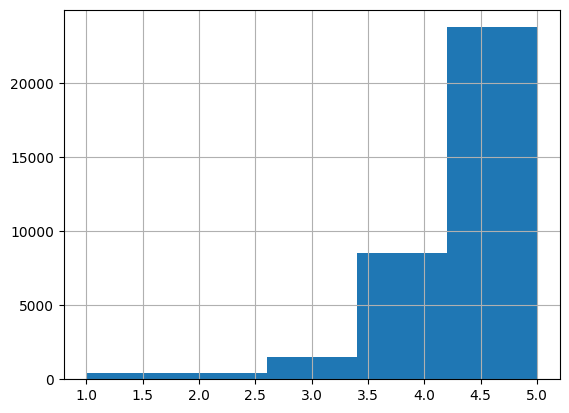

In [12]:
# Visualize the distribution of ratings using a histogram
df['reviews.rating'].hist(bins=5)